## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from LogicalQ.Logical import LogicalCircuit
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Library.HardwareModels import hardware_models_Quantinuum
from LogicalQ.Experiments import execute_circuits

import numpy as np
 
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList, Statevector, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_addon_cutting import (
    cut_gates,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
 
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit_aer import AerSimulator

from tqdm.notebook import tqdm

from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, state_fidelity
from scipy.linalg import expm


from qiskit.transpiler import PassManager
from LogicalQ.Transpilation.UnBox import UnBoxTask
from bqskit.passes import TreeScanningGateRemovalPass

from bqskit import MachineModel, Circuit
from bqskit.compiler import Workflow
from bqskit.ext import qiskit_to_bqskit
from bqskit.passes import LEAPSynthesisPass
from bqskit.ir.gates import (
    SGate, SdgGate, TGate, TdgGate, HGate,
    XGate, YGate, ZGate, CZGate, CXGate
)
from qiskit import QuantumCircuit # For creating a placeholder circuit

%load_ext autoreload
%autoreload 2

## Transverse Ising Model

https://www.science.org/doi/epdf/10.1126/science.1208001

TBF later

## Asymmetric Heisingberg Model

### Optimal Clifford + T approximation
"Optimal ancilla-free Clifford+T approximation of z-rotations" https://arxiv.org/pdf/1403.2975

This paper could be useful in the future if it were extended to x-/y-rotations as well. However, implementation and understanding it seems far more difficult. Also, we do not have the factoring oracle required.

### Solovay-Kitaev Algorithm

In [2]:
from qiskit.transpiler.passes import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.circuit.library import RXGate, RYGate, RZGate, RXXGate, RYYGate, RZZGate

In [3]:
qc = QuantumCircuit(2)
qc.rx(theta = np.pi/4, qubit = 0)
qc.draw()

┌─────────┐
q_0: ┤ Rx(π/4) ├
     └─────────┘
q_1: ───────────

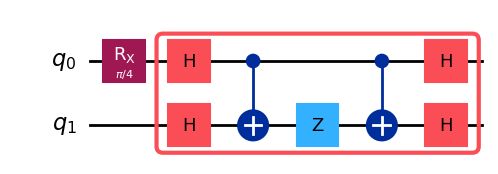

In [4]:
def append_rot_gate(qc, axis = "z", theta = 0, qubit_indices = [0], label = None, return_subcircuit = False, depth = 10, recursion_degree = 1, box=True):
    gates = {"x": (RXGate, 1), "y": (RYGate, 1), "z": (RZGate, 1), "xx": (RXXGate, 2), "yy": (RYYGate, 2), "zz": (RZZGate, 2)}
    gate_base, num_target_qubits = gates[axis]
    gate = gate_base(theta)
    
    sub_qc = QuantumCircuit(num_target_qubits)
 
    def apply_Rzz(sub_qc):
        sub_qc.cx(0, 1)
        sub_qc.rz(theta, 1)
        sub_qc.cx(0, 1)
 
    match axis:
        case "xx":
            sub_qc.h([0, 1])
            apply_Rzz(sub_qc)
            sub_qc.h([0, 1])
        case "yy":
            sub_qc.rx(np.pi / 2, [0, 1])
            apply_Rzz(sub_qc)
            sub_qc.rx(-np.pi / 2, [0, 1])
        case "zz":
            apply_Rzz(sub_qc)
        case _:        
            sub_qc.append(gate, qargs = list(range(num_target_qubits)))
    
    basis = ["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
    approx = generate_basic_approximations(basis, depth=depth)
    skd = SolovayKitaev(recursion_degree=recursion_degree, basic_approximations=approx)

    discretized_sub_qc = skd(sub_qc)
    box_label = fr"S-K: R$_\text{{{axis}}}$({np.round(theta / np.pi, 2)}$\pi$)" if label == None else label
    def append_all():
        for i in range(len(discretized_sub_qc.data)):
                circuit_instruction = discretized_sub_qc.data[i]
                qc.append(circuit_instruction)
    
    
    if box:
        if isinstance(qc, LogicalCircuit):
            with qc.box(label="logical.logicalop.R:{box_label}"):
                append_all()
        elif isinstance(qc, QuantumCircuit):
            with qc.box(label="R:{box_label}"):
                append_all()
        else:
            raise AssertionError("qc is not a valid QuantumCircuit or LogicalCircuit.")
    else:
        append_all()
        #sub_gate = discretized_sub_qc.to_gate(label=box_label)
        #qc.append(sub_gate, qubit_indices)
    
    if return_subcircuit:
        return qc, discretized_sub_qc
    else:
        return qc

qc = append_rot_gate(qc, "xx", np.pi, [0, 1])
qc.draw(output="mpl")

In [5]:
"""
def append_rot_gate(qc, axis = "z", theta = 0, qubit_indices = [0], label = None, return_subcircuit = False, quality = 4):
    gates = {"x": (RXGate, 1), "y": (RYGate, 1), "z": (RZGate, 1), "xx": (RXXGate, 2), "yy": (RYYGate, 2), "zz": (RZZGate, 2)}
    gate_base, num_target_qubits = gates[axis]
    gate = gate_base(theta)
    
    sub_qc = QuantumCircuit(num_target_qubits)
 
    def apply_Rzz(sub_qc):
        sub_qc.cx(0, 1)
        sub_qc = append_rot_gate(sub_qc, "z", theta, [1], quality=quality)
        #sub_qc.rz(theta, 1)
        sub_qc.cx(0, 1)
 
    match axis:
        case "xx":
            sub_qc.h([0, 1])
            apply_Rzz(sub_qc)
            sub_qc.h([0, 1])
            discretized_sub_qc = sub_qc
        case "yy":
            #sub_qc.rx(np.pi / 2, [0, 1])
            sub_qc = append_rot_gate(sub_qc, "x", np.pi / 2, [0], quality=quality)
            sub_qc = append_rot_gate(sub_qc, "x", np.pi / 2, [1], quality=quality)
            apply_Rzz(sub_qc)
            #sub_qc.rx(-np.pi / 2, [0, 1])
            sub_qc = append_rot_gate(sub_qc, "x", -np.pi / 2, [0], quality=quality)
            sub_qc = append_rot_gate(sub_qc, "x", -np.pi / 2, [1], quality=quality)
            discretized_sub_qc = sub_qc
        case "zz":
            apply_Rzz(sub_qc)
            discretized_sub_qc = sub_qc
        case _:        
            sub_qc.append(gate, qargs = list(range(num_target_qubits)))
    
            basis = ["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
            approx = generate_basic_approximations(basis, depth=3)
            skd = SolovayKitaev(recursion_degree=quality, basic_approximations=approx)

            discretized_sub_qc = skd(sub_qc)
            
    box_label = fr"S-K: R$_\text{{{axis}}}$({np.round(theta / np.pi, 2)}$\pi$)" if label == None else label
    if isinstance(qc, LogicalCircuit):
        with qc.box(label="logical.logicalop.R:{box_label}"):
            for i in range(len(sub_qc.data)):
                circuit_instruction = discretized_sub_qc.data[i]
                qc.append(circuit_instruction)
    elif isinstance(qc, QuantumCircuit):
        sub_gate = discretized_sub_qc.to_gate(label=box_label)
        qc.append(sub_gate, qubit_indices)
    else:
        raise AssertionError("qc is not a valid QuantumCircuit or LogicalCircuit.")
    
    if return_subcircuit:
        return qc, discretized_sub_qc
    else:
        return qc

qc = append_rot_gate(qc, "xx", np.pi, [0, 1])
qc.draw(output="mpl")
"""

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\nolan\AppData\Local\Temp\ipykernel_49116\117147892.py:1: SyntaxWarning: invalid escape sequence '\p'
  """


'\ndef append_rot_gate(qc, axis = "z", theta = 0, qubit_indices = [0], label = None, return_subcircuit = False, quality = 4):\n    gates = {"x": (RXGate, 1), "y": (RYGate, 1), "z": (RZGate, 1), "xx": (RXXGate, 2), "yy": (RYYGate, 2), "zz": (RZZGate, 2)}\n    gate_base, num_target_qubits = gates[axis]\n    gate = gate_base(theta)\n\n    sub_qc = QuantumCircuit(num_target_qubits)\n\n    def apply_Rzz(sub_qc):\n        sub_qc.cx(0, 1)\n        sub_qc = append_rot_gate(sub_qc, "z", theta, [1], quality=quality)\n        #sub_qc.rz(theta, 1)\n        sub_qc.cx(0, 1)\n\n    match axis:\n        case "xx":\n            sub_qc.h([0, 1])\n            apply_Rzz(sub_qc)\n            sub_qc.h([0, 1])\n            discretized_sub_qc = sub_qc\n        case "yy":\n            #sub_qc.rx(np.pi / 2, [0, 1])\n            sub_qc = append_rot_gate(sub_qc, "x", np.pi / 2, [0], quality=quality)\n            sub_qc = append_rot_gate(sub_qc, "x", np.pi / 2, [1], quality=quality)\n            apply_Rzz(sub_qc)\

In [6]:
#sub_qc.draw(output="mpl")

### Rxx, Ryy, Rzz Gate Validations

In [7]:
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()

ratio = 7 / 33 # picked a weird fraction of pi to make the test more robust

Rzz_ref = QuantumCircuit(2)
Rzz_ref.rzz(ratio * np.pi, 0, 1)

state = Statevector.from_instruction(Rzz_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [8]:
Rzz_alg = QuantumCircuit(2)
Rzz_alg = append_rot_gate(Rzz_alg, "zz", ratio * np.pi, qubit_indices=[0,1])

state = Statevector.from_instruction(Rzz_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [9]:
ratio = 15 / 33 # picked a weird fraction of pi to make the test more robust

Rxx_ref = QuantumCircuit(2)
Rxx_ref.rxx(ratio * np.pi, 0, 1)

state = Statevector.from_instruction(Rxx_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [10]:
Rxx_alg = QuantumCircuit(2)
Rxx_alg = append_rot_gate(Rxx_alg, "xx", ratio * np.pi, qubit_indices=[0,1])

state = Statevector.from_instruction(Rxx_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [11]:
ratio = 19 / 33 # picked a weird fraction of pi to make the test more robust

Ryy_ref = QuantumCircuit(2)
Ryy_ref.rxx(ratio * np.pi, 0, 1)

state = Statevector.from_instruction(Ryy_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [12]:
Ryy_alg = QuantumCircuit(2)
Ryy_alg = append_rot_gate(Ryy_alg, "yy", ratio * np.pi, qubit_indices=[0,1])

state = Statevector.from_instruction(Ryy_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

### Build AH model

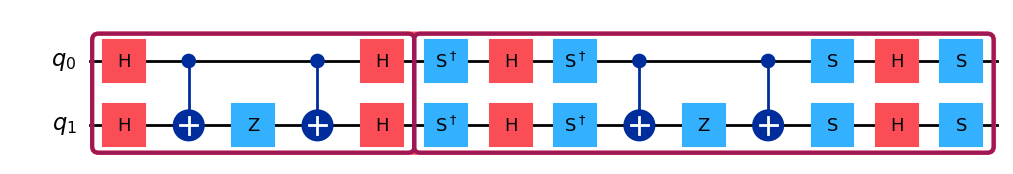

In [13]:
def Hxy(dt, J):
    theta = dt * J
    
    qc = QuantumCircuit(2)
    with qc.box(label="Hxy"):
        qc = append_rot_gate(qc, "xx", theta, [0, 1])
        qc = append_rot_gate(qc, "yy", theta, [0, 1])
    return qc

qc_test = QuantumCircuit(2)
H_xy = Hxy(1.0, np.pi)
qc_test = qc_test.compose(H_xy, [0, 1], front=True)
qc_test.draw(output="mpl")

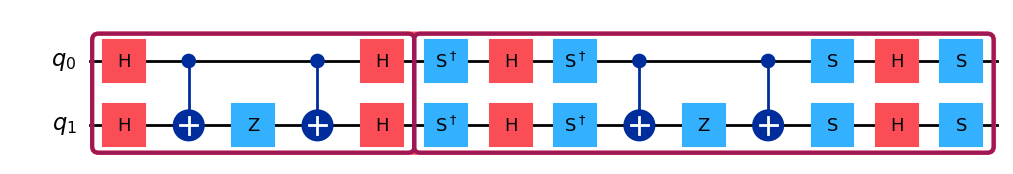

In [14]:
H_xy.draw(output='mpl')

In [15]:
def get_heisenberg_model_circuit(dt, J, depth = 10, recursion_degree = 1, initial_sv = None):
    qc = QuantumCircuit(2)
    
    if isinstance(initial_sv, Statevector):
        qc.initialize(initial_sv, [0,1])
    
    theta = J * dt
    append_rot_gate(qc, "xx", 2 * theta, [0, 1], depth=depth, recursion_degree=recursion_degree)
    append_rot_gate(qc, "yy", 2 * theta, [0, 1], depth=depth, recursion_degree=recursion_degree)
    append_rot_gate(qc, "zz", 2 * theta, [0, 1], depth=depth, recursion_degree=recursion_degree)
    
    """
    # Hxy
    qc.append(Hxy_box, qargs = [0,1])
    
    # Hxz
    qc = append_rot_gate(qc, axis="y", theta=-np.pi/4, qubit_indices=[0])
    qc = append_rot_gate(qc, axis="y", theta=-np.pi/4, qubit_indices=[1])
    qc.append(Hxy_box, qargs = [0,1])
    qc = append_rot_gate(qc, axis="y", theta=np.pi/4, qubit_indices=[0])
    qc = append_rot_gate(qc, axis="y", theta=np.pi/4, qubit_indices=[1])
    
    # Hyz
    qc = append_rot_gate(qc, axis="x", theta=-np.pi/4, qubit_indices=[0])
    qc = append_rot_gate(qc, axis="x", theta=-np.pi/4, qubit_indices=[1])
    qc.append(Hxy_box, qargs = [0,1])
    qc = append_rot_gate(qc, axis="x", theta=np.pi/4, qubit_indices=[0])
    qc = append_rot_gate(qc, axis="x", theta=np.pi/4, qubit_indices=[1])
    """
    
    return qc

In [16]:
qc = get_heisenberg_model_circuit(0.01, 1)

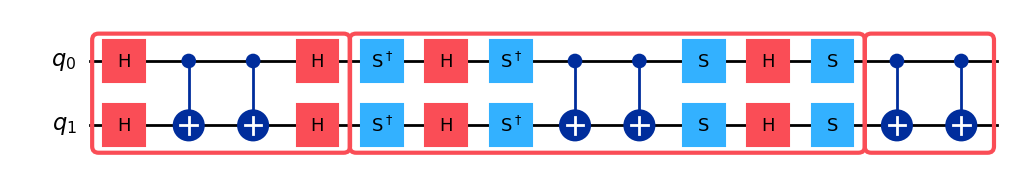

In [17]:
qc.draw(output="mpl")

## Matching paper results

We are going to initialize our 2-qubit system in the $\frac{1}{\sqrt{5}}(\ket{\uparrow}+2\ket{\downarrow})\otimes \ket{\downarrow}$ state, and then graph expectation values and fidelity as a function of $\theta$.

### Validate noiseless AH quantum circuit

In [18]:
def get_op_count(qc):

    op_counts = qc.count_ops()
    print(f"\nDetailed operation counts: {op_counts}")

    num_measurements = op_counts.get('measure', 0)
    print(f"Number of measurements: {num_measurements}")

    total_ops =qc.size()
    print(f"Total number of operations: {total_ops}")

  0%|          | 0/20 [00:00<?, ?it/s]

Optimized simulation complete!
Stored data for 20 time steps.


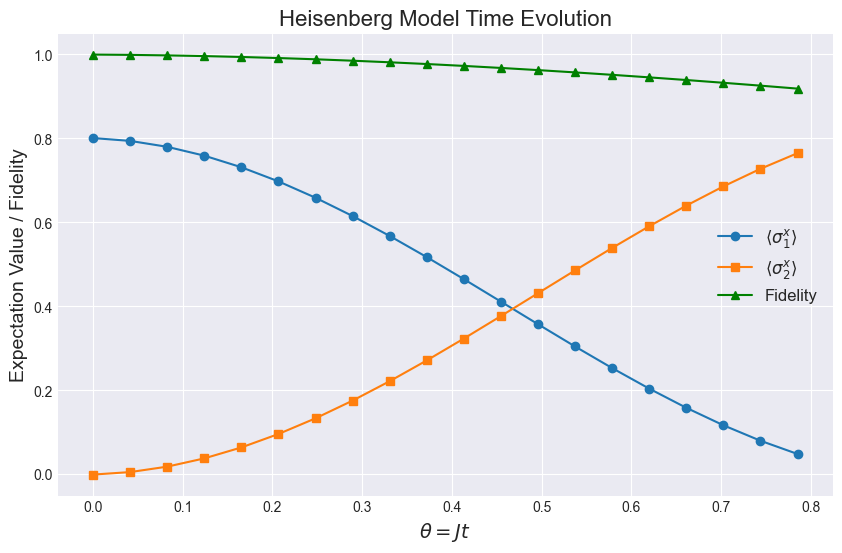

In [19]:
J_coupling = 2 * np.pi * 6E6
theta_final = np.pi / 4
num_steps = 20
thetas = np.linspace(0, theta_final, num_steps)
dt = (theta_final / J_coupling) / num_steps

# Initial state: 1/sqrt(5) * (|0> + 2|1>) @ |1>  = 1/sqrt(5) * (|01> + 2|11>)
initial_state_vector = np.array([1, 0, 2, 0]) / np.sqrt(5)
initial_sv = Statevector(initial_state_vector)

# Define observables for expectation values
X1 = SparsePauliOp("XI")
X2 = SparsePauliOp("IX")

# H = J * (XX + YY + ZZ)
heisenberg_hamiltonian = J_coupling * (
    SparsePauliOp("XX") + SparsePauliOp("YY") + SparsePauliOp("ZZ")
)
H_matrix = heisenberg_hamiltonian.to_matrix()

trotter_step_circuit = get_heisenberg_model_circuit(dt, J_coupling, depth=20, recursion_degree=1)
pm = PassManager([UnBoxTask()])
trotter_decomp = pm.run(trotter_step_circuit)
#get_op_count(trotter_step_circuit.decompose())
#transpiled_qc = transpile(trotter_step_circuit.decompose(), optimization_level=3, basis_gates=["unitary", "cx", "cy", "cz"])
#basis = ["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
#approx = generate_basic_approximations(basis, depth=14)
#skd = SolovayKitaev(recursion_degree=3, basic_approximations=approx)
#trotter_step_circuit = skd(transpiled_qc)
#get_op_count(transpiled_qc)
#get_op_count(trotter_step_circuit.decompose())

results = {
    "statevectors": [],
    "exp_x1": [],
    "exp_x2": [],
    "fidelities": []
}

# Start with a copy of the initial statevector
current_sv = initial_sv.copy()

for step in tqdm(range(num_steps)):
    # Evolve current statevector by 1 iter.
    current_sv = current_sv.evolve(trotter_decomp)
    results["statevectors"].append(current_sv.copy())
    
    # Calculate exp. values
    exp_x1 = current_sv.expectation_value(X1).real
    exp_x2 = current_sv.expectation_value(X2).real
    results["exp_x1"].append(exp_x1)
    results["exp_x2"].append(exp_x2)
    
    # Calculate fidelity
    current_time = (step + 1) * dt
    U_ideal = expm(-1j * H_matrix * current_time)
    ideal_sv = Statevector(np.dot(U_ideal, initial_state_vector))
    fidelity = state_fidelity(current_sv, ideal_sv)
    results["fidelities"].append(fidelity)

print("Optimized simulation complete!")
print(f"Stored data for {len(results['statevectors'])} time steps.")

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thetas, results["exp_x1"], 'o-', label=r'$\langle\sigma_1^x\rangle$')
ax.plot(thetas, results["exp_x2"], 's-', label=r'$\langle\sigma_2^x\rangle$')
ax.plot(thetas, results["fidelities"], '^-', label='Fidelity', color='green')

ax.set_xlabel(r'$\theta = Jt$', fontsize=14)
ax.set_ylabel('Expectation Value / Fidelity', fontsize=14)
ax.set_title('Heisenberg Model Time Evolution', fontsize=16)
ax.legend(fontsize=12)
plt.show()

In [20]:
pm = PassManager([UnBoxTask()])
trotter_decomp = pm.run(trotter_step_circuit)
get_op_count(trotter_decomp)
#decomposed_circuit = trotter_step_circuit.decompose()
unboxed_circuit.draw(output="mpl")


Detailed operation counts: OrderedDict({'h': 116, 't': 54, 'tdg': 54, 's': 7, 'sdg': 7, 'cx': 6})
Number of measurements: 0
Total number of operations: 244


NameError: name 'unboxed_circuit' is not defined

In [ ]:
decomposed_circuit = unboxed_circuit.decompose()


In [ ]:
#decomposed_circuit.draw(output="mpl")

Check op count of physical circuit

Recorded data:

quality = 4  ->  number of ops = 

quality = 7  ->  number of ops = 

### Optimize circuit depth

Attempt 1: Using qiskit transpilation

In [16]:
#trotter_step_circuit.draw(output="mpl")
trotter_decomp = trotter_step_circuit.decompose()
#trotter_decomp.draw(output="mpl")

In [ ]:
circuit = trotter_step_circuit
 

simulator = AerSimulator()

#pm = generate_preset_pass_manager(
#    optimization_level=3, initial_layout=[0, 1], basis_gates=["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
#)
#transpiled_qc = pm.run(circuit)

transpiled_qc = transpile(trotter_decomp, optimization_level=3)

In [ ]:
transpiled_qc.draw(output="mpl")

In [35]:
get_op_count(transpiled_qc)


Detailed operation counts: OrderedDict({'h': 29891, 'tdg': 13182, 't': 13176, 's': 2569, 'sdg': 2563, 'cz': 6, 'z': 2})
Number of measurements: 0
Total number of operations: 61389


Attempt 2: Using BQSKit processing passes to remove gates

In [36]:
from bqskit.compiler import Workflow
from bqskit.ext import qiskit_to_bqskit

qc = trotter_decomp

circuit = qiskit_to_bqskit(qc)
from bqskit import compile
out_circuit = compile(circuit)

#workflow = Workflow([TreeScanningGateRemovalPass(tree_depth=3)])
#compiled_circuit = compile(circuit)
#pm = PassManager()
#pruned_circuit = pm.run(trotter_step_circuit)

#print("Compiled Circuit Statistics")
#print("Gate Counts:", out_circuit.gate_counts)
#print("Connectivity:", out_circuit.coupling_graph)

from bqskit.ir.gates import CZGate, RZGate, SXGate
gate_set = {CZGate(), RZGate(), SXGate()} 

# Build a MachineModel with this gate set
# and the same number of qubits as the circuit
from bqskit import MachineModel
model = MachineModel(out_circuit.num_qudits, gate_set=gate_set)

def compile_to_gateset(circuit, gate_set):
    model = MachineModel(circuit.num_qudits, gate_set=gate_set)
    return compile(circuit, model=model)

# BGate CCXGate ToffoliGate CHGate ClockGate CPIGate CSGate CSUMGate CTGate CNOTGate CXGate CYGate CZGate ECRGate HGate IdentityGate ISwapGate IToffoliGate PDGate PermutationGate MargolusGate RC3XGate RCCXGate SGate SdgGate ShiftGate SqrtCNOTGate SqrtISwapGate SqrtTGate SubSwapGate SwapGate SqrtXGate SXGate SycamoreGate TGate TdgGate ConstantUnitaryGate XGate XXGate YGate YYGate ZGate ZZGate
# ["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
from bqskit.ir.gates import ZZGate, SGate, SdgGate, TGate, TdgGate, HGate, XGate, YGate, ZGate, CZGate, CXGate
quantinuum_like_gate_set = {ZZGate(), RZGate(), SXGate()}
CliffordT_gate_set = {SGate(), SdgGate(), TGate(), TdgGate(), HGate(), XGate(), YGate(), ZGate(), CZGate(), CXGate()}

out_circuit = compile_to_gateset(circuit, CliffordT_gate_set)

c:\Users\nolan\OneDrive\Desktop\College\Research\Quantum Computing\QCA\clone\LogicalQ\venv\Lib\site-packages\lark\parse_tree_builder.py:154: RuntimeWarning: coroutine 'Workflow.run' was never awaited
  filtered.append(children[i])
The standard workflow with BQSKit may have trouble targeting gate sets containing no parameterized single-qudit gates. [wid=9]
Compiler interrupted.


KeyboardInterrupt: 

In [ ]:
from bqskit.passes import UnfoldPass
from bqskit.compiler import Compiler
qc = trotter_decomp
circuit = qiskit_to_bqskit(qc)

CliffordT_gate_set = {
    SGate(), SdgGate(), TGate(), TdgGate(), HGate(),
    XGate(), YGate(), ZGate(), CZGate(), CXGate()
}

model = MachineModel(
    circuit.num_qudits,
    gate_set=CliffordT_gate_set
)

workflow = Workflow([
    
    UnfoldPass(),
    LEAPSynthesisPass()
])

with Compiler() as compiler:
    opt_circuit = compiler.compile(circuit, workflow=workflow)
    
#compiled_circuit = workflow.run(circuit, model)

TypeError: LEAPSynthesisPass.__init__() got an unexpected keyword argument 'gate_set'

In [ ]:
import bqskit
from bqskit.ir.gates import SGate, SdgGate, TGate, TdgGate, HGate, XGate, YGate, ZGate, CZGate, CNOTGate
from bqskit.compiler import Compiler
from bqskit.passes import ScanPartitioner, LEAPSynthesisPass, SetModelPass
from bqskit.ext import qiskit_to_bqskit
from bqskit.compiler import Workflow

circuit = bqskit.Circuit(4) # Placeholder circuit

model = MachineModel(
    circuit.num_qudits,
    gate_set=CliffordT_gate_set
)

workflow = Workflow([
    SetModelPass(model),
    ScanPartitioner(block_size=3),
    LEAPSynthesisPass() 
])

with Compiler() as compiler:
    opt_circuit = compiler.compile(circuit, workflow=workflow)

print("Circuit Statistics")
print("Gate Counts:", opt_circuit.gate_counts)
print("Logical Connectivity:", opt_circuit.coupling_graph)
output_gates = {g.name for g in opt_circuit.gate_set}
expected_gates = {g.name for g in CliffordT_gate_set}
print(f"Output gates are a subset of Clifford+T: {output_gates.issubset(expected_gates)}")

Circuit Statistics
Gate Counts: {U3Gate: 4}
Logical Connectivity: CouplingGraph(set())
Output gates are a subset of Clifford+T: False


In [40]:
type(opt_circuit)

bqskit.ir.circuit.Circuit

In [ ]:
print("\nCompiled Circuit Statistics:")
print(f"New gate count: {compiled_circuit.gate_counts.total}")
print("Gate Counts:", compiled_circuit.gate_counts)

In [41]:
print("Compiled Circuit Statistics")
print("Gate Counts:", compiled_circuit.gate_counts)
print("Connectivity:", compiled_circuit.coupling_graph)

Compiled Circuit Statistics
Gate Counts: {RXGate: 3, CNOTGate: 3, RZGate: 3, RYGate: 6, U3Gate: 2}
Connectivity: CouplingGraph({(0, 1)})


quantinuum like
Compiled Circuit Statistics
Gate Counts: {ZZGate: 3, RZGate: 24, SqrtXGate: 16}
Connectivity: CouplingGraph({(0, 1)})

### Validate LogicalCircuit transpilation

In [21]:
pm = PassManager([UnBoxTask()])
trotter_decomp = pm.run(trotter_step_circuit)

set([op.name for op in trotter_decomp.data])

{'cx', 'h', 's', 'sdg', 't', 'tdg'}

In [22]:
J_coupling = 2 * np.pi * 6E6
theta_final = np.pi / 4
num_steps = 20
dt = (theta_final / J_coupling) / num_steps

initial_state_vector = np.array([1, 0, 2, 0]) / np.sqrt(5)
initial_sv = Statevector(initial_state_vector)

trotter_step_circuit = get_heisenberg_model_circuit(dt, J_coupling, depth=20, recursion_degree=1, initial_sv=initial_sv)
#trotter_decomp = trotter_step_circuit.decompose(gates_to_decompose='circuit')
pm = PassManager([UnBoxTask()])
trotter_decomp = pm.run(trotter_step_circuit)

#trotter_decomp.initialize(current_sv, [0,1])

In [61]:
set([op.name for op in trotter_decomp.data])

{'cx', 'h', 'initialize', 'sdg', 't'}

In [61]:
Statevector(trotter_decomp.data[0].params)

Statevector([0.4472136 +0.j, 0.        +0.j, 0.89442719+0.j,
             0.        +0.j],
            dims=(2, 2))


In [57]:
trotter_step_circuit.data

[CircuitInstruction(operation=Instruction(name='initialize', num_qubits=2, num_clbits=0, params=[(0.4472135954999579+0j), 0j, (0.8944271909999159+0j), 0j]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=()), CircuitInstruction(operation=Instruction(name='box', num_qubits=2, num_clbits=0, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D2B1EB7050>]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=()), CircuitInstruction(operation=Instruction(name='box', num_qubits=2, num_clbits=0, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D2AFCB1760>]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=()), CircuitInstruction(operation=Instruction(name='box', num_qubits=2, num_clbits=0, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D2B1EB67B0>]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=

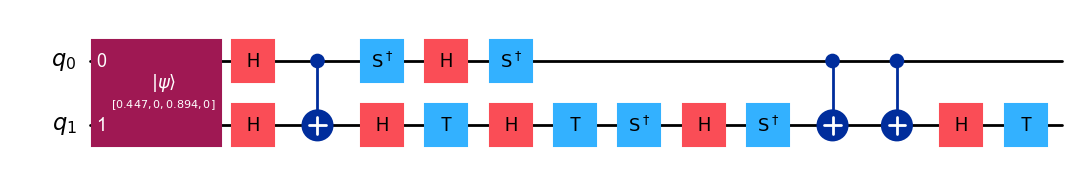

In [60]:
trotter_decomp.draw(output='mpl')

In [23]:
lqcirc = LogicalCircuit.from_physical_circuit(trotter_decomp, **steane_code)    
lqcirc.encode([0, 1])
lqcirc.measure([0, 1], [0, 1], with_error_correction=False)

pm = PassManager([UnBoxTask()])
unboxed_circuit = pm.run(lqcirc)
#unboxed_circuit.draw(output="mpl")

RecursionError: maximum recursion depth exceeded

In [22]:
unboxed_circuit.count_ops()

OrderedDict([('h', 1304),
             ('clogical.logicalop.z.transversal:$\\hat{Z}_{L}$', 380),
             ('clogical.logicalop.x.transversal:$\\hat{X}_{L}$', 238),
             ('cclogical.logicalop.z.transversal:$\\hat{Z}_{L}$', 216),
             ('s', 122),
             ('sdg', 122),
             ('x', 117),
             ('t', 108),
             ('tdg', 108),
             ('cx', 56),
             ('reset', 32),
             ('measure', 18),
             ('if_else', 2)])

In [38]:
print(f"Num ops: {sum(list(unboxed_circuit.count_ops().values()))}")

Num ops: 2823


In [ ]:
# Sim parameters
J_coupling = 2 * np.pi * 6E6
theta_final = np.pi / 4
num_steps = 20
thetas = np.linspace(0, theta_final, num_steps)
dt = (theta_final / J_coupling) / num_steps

# Initial state: 1/sqrt(5) * (|0> + 2|1>) @ |1>  = 1/sqrt(5) * (|01> + 2|11>)
initial_state_vector = np.array([1, 0, 2, 0]) / np.sqrt(5)
initial_sv = Statevector(initial_state_vector)

# Define observables for expectation values
X1 = SparsePauliOp("XI")
X2 = SparsePauliOp("IX")

# H = J * (XX + YY + ZZ)
heisenberg_hamiltonian = J_coupling * (
    SparsePauliOp("XX") + SparsePauliOp("YY") + SparsePauliOp("ZZ")
)
H_matrix = heisenberg_hamiltonian.to_matrix()

#trotter_step_circuit = get_heisenberg_model_circuit(dt, J_coupling, depth=20, recursion_degree=1)
#transpiled_qc = transpile(trotter_step_circuit.decompose(), optimization_level=3, basis_gates=["unitary", "cx", "cy", "cz"])
#basis = ["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
#approx = generate_basic_approximations(basis, depth=14)
#skd = SolovayKitaev(recursion_degree=3, basic_approximations=approx)
#trotter_step_circuit = skd(transpiled_qc)
#get_op_count(transpiled_qc)
#get_op_count(trotter_step_circuit.decompose())

results = {
    "statevectors": [],
    "exp_x1": [],
    "exp_x2": [],
    "fidelities": []
}

# Start with a copy of the initial statevector
current_sv = initial_sv.copy()

for step in tqdm(range(num_steps)):
    
    # Evolve current statevector by 1 iter.
    #current_sv = current_sv.evolve(lg_trotter_step_circuit)
    #trotter_step_circuit.initialize(current_sv)
    trotter_step_circuit = get_heisenberg_model_circuit(dt, J_coupling, depth=20, recursion_degree=1, initial_sv=current_sv)
    lqcirc = LogicalCircuit.from_physical_circuit(trotter_step_circuit.decompose(), **steane_code)
    lqcirc.encode(0)
    lqcirc.measure([0, 1], [0, 1], with_error_correction=False)
    
    if step == 0:
        get_op_count(lqcirc.decompose(reps=2))
        print(lqcirc.count_ops())
    
    result = execute_circuits(lqcirc, backend="aer_simulator", hardware_model=hardware_models_Quantinuum["H2-1"], coupling_map=None, shots=1, save_statevector=True)[0]
    #output = result.get_memory(lqcirc)
    #counts = lqcirc.get_logical_counts(output)
    current_sv = result["statevector"]
    
    results["statevectors"].append(current_sv.copy())
    
    # Calculate exp. values
    exp_x1 = current_sv.expectation_value(X1).real
    exp_x2 = current_sv.expectation_value(X2).real
    results["exp_x1"].append(exp_x1)
    results["exp_x2"].append(exp_x2)
    
    # Calculate fidelity
    current_time = (step + 1) * dt
    U_ideal = expm(-1j * H_matrix * current_time)
    ideal_sv = Statevector(np.dot(U_ideal, initial_state_vector))
    fidelity = state_fidelity(current_sv, ideal_sv)
    results["fidelities"].append(fidelity)

print("Optimized simulation complete!")
print(f"Stored data for {len(results['statevectors'])} time steps.")

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thetas, results["exp_x1"], 'o-', label=r'$\langle\sigma_1^x\rangle$')
ax.plot(thetas, results["exp_x2"], 's-', label=r'$\langle\sigma_2^x\rangle$')
ax.plot(thetas, results["fidelities"], '^-', label='Fidelity', color='green')

ax.set_xlabel(r'$\theta = Jt$', fontsize=14)
ax.set_ylabel('Expectation Value / Fidelity', fontsize=14)
ax.set_title('Heisenberg Model Time Evolution', fontsize=16)
ax.legend(fontsize=12)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

CircuitError: 'Bit \'<Qubit register=(2, "q"), index=0>\' is not in the circuit.'

### Benchmark QEC


Detailed operation counts: OrderedDict({'u': 8, 'cx': 3})
Number of measurements: 0
Total number of operations: 11

Detailed operation counts: OrderedDict({'h': 53, 't': 28, 'tdg': 28, 'sdg': 3, 'z': 3, 'cx': 3, 'x': 3, 's': 1})
Number of measurements: 0
Total number of operations: 122


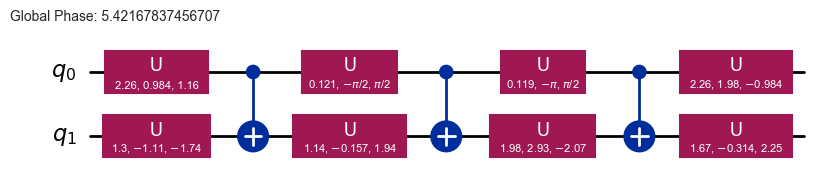

In [72]:
trotter_step_circuit = get_heisenberg_model_circuit(dt, J_coupling, quality = 4)
transpiled_qc = transpile(trotter_step_circuit.decompose(), optimization_level=3, basis_gates=["u", "cz", "cx"])
basis = ["s", "sdg", "t", "tdg", "h", "x", "y", "z", "cz"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
trotter_step_circuit = skd(transpiled_qc)
get_op_count(transpiled_qc)
get_op_count(trotter_step_circuit)
transpiled_qc.draw(output="mpl")